# SSL (Cont. from IY011)

In [1]:
import torch
import torch.optim as optim
from pathlib import Path
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

from dataloaders.simclr import ssl_data_prep
from dataloaders import  save_loader_to_disk
from models.ssl_transformer import SSL_Transformer
from training.train import train_ssl_model
from info_nce import InfoNCE
import wandb
%load_ext autoreload
%autoreload 2  

In [2]:
# Setup Configuration
DATA_ROOT = Path("/home/ianyang/stochastic_simulations/experiments/EXP-25-IY011/data_mu_variation")
RESULTS_PATH = DATA_ROOT / "IY011_simulation_mu_parameters_sobol.csv" #  this csv file stores all the simulation parameters used
df_params = pd.read_csv(RESULTS_PATH) 
TRAJ_PATH = [DATA_ROOT / df_params['trajectory_filename'].values[i] for i in range(len(df_params))]
TRAJ_NPZ_PATH = [traj_file.with_suffix('.npz') for traj_file in TRAJ_PATH]

In [3]:
# === Dataloader hyperparams & data prep ===
batch_size = 64
num_traj=1 # number of trajectories per view
sample_len=None
log_scale = False 
instance_norm = False

train_loader, val_loader, test_loader, scaler = ssl_data_prep(
    TRAJ_NPZ_PATH,
    batch_size=batch_size,
    sample_len=sample_len,
    log_scale=log_scale,
    instance_norm=instance_norm,
    num_traj=num_traj,
)
# === Dataloader hyperparams & data prep ===

Files split: 655 Train, 164 Val, 205 Test
Loading and grouping 655 files...


Loading Files:   0%|          | 0/655 [00:00<?, ?it/s]

Loading Files: 100%|██████████| 655/655 [00:24<00:00, 26.60it/s]


Loading and grouping 164 files...


Loading Files: 100%|██████████| 164/164 [00:06<00:00, 26.28it/s]


Loading and grouping 205 files...


Loading Files: 100%|██████████| 205/205 [00:07<00:00, 26.50it/s]

Total Unique Systems (Files): 655 Train, 164 Val
Detected/Set Sample Length (per traj): 2510


In [4]:
# === Save data for debugging later === 
# 1. Define paths
train_save_path = DATA_ROOT / "IY016_static_train_demo.pt"
val_save_path   = DATA_ROOT / "IY016_static_val_demo.pt"
test_save_path  = DATA_ROOT / "IY016_static_test_demo.pt"

# 2. Check if static data already exists
# if not train_save_path.exists():
#     print("Static data not found. Saving...")
    
#     # Save them to disk
#     save_loader_to_disk(train_loader, train_save_path)
#     save_loader_to_disk(val_loader, val_save_path)
#     save_loader_to_disk(test_loader, test_save_path)
# else:
#     print("Found existing static data on disk, the simulated data will not be saved, to prevent overwriting existing data.")
# === Save data for debugging later === 

Visualise the views generated for SSL: X1 and X2 should both be trajectories from the same file

torch.Size([64, 2510, 1]) torch.Size([64, 2510, 1]) torch.Size([64, 1])


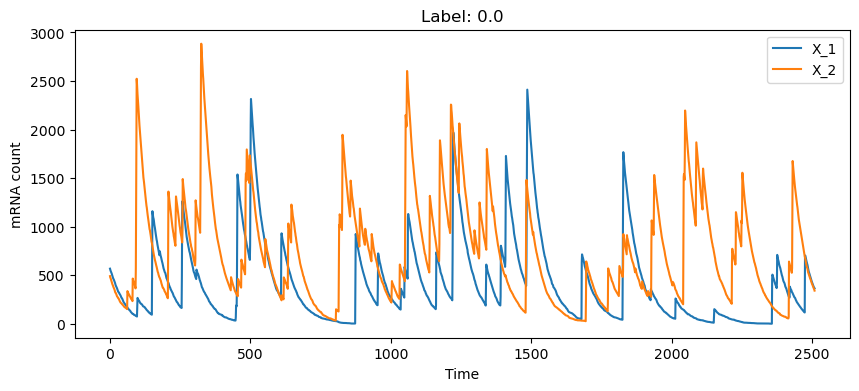

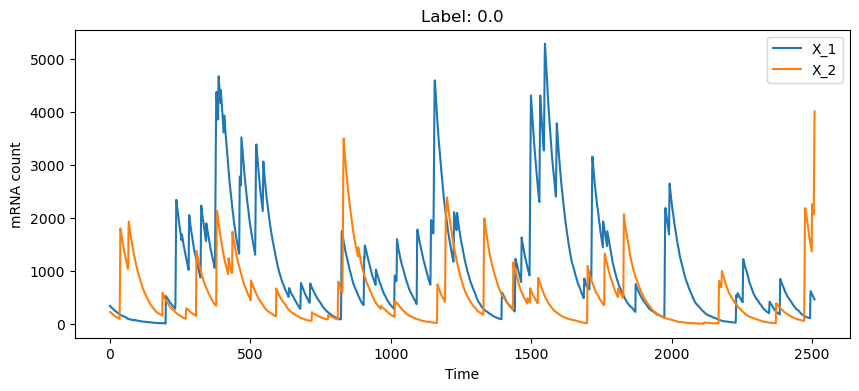

In [5]:
X1_b, X2_b, y_b = next(iter(train_loader))
print(X1_b.shape, X2_b.shape, y_b.shape) # (B, T, 1) (B, T, 1) (B, 1)

# plot the first pair in the batch
plt.figure(figsize=(10,4))
plt.plot(X1_b[0,:,0].numpy(), label='X_1')
plt.plot(X2_b[0,:,0].numpy(), label='X_2')
plt.title(f"Label: {y_b[0].item()}")
plt.xlabel("Time")
plt.ylabel("mRNA count")
plt.legend()
plt.show()

# plot another pair in the batch
plt.figure(figsize=(10,4))
plt.plot(X1_b[1,:,0].numpy(), label='X_1')
plt.plot(X2_b[1,:,0].numpy(), label='X_2')
plt.title(f"Label: {y_b[1].item()}")
plt.xlabel("Time")
plt.ylabel("mRNA count")
plt.legend()
plt.show()

LARS Optimizer (Layer-wise Adaptive Rate Scaling)

In [6]:
# # LARS optimizer to be used for SSL
# from torch.optim.optimizer import Optimizer

# class LARS(Optimizer):
#     """
#     LARS Optimizer (Layer-wise Adaptive Rate Scaling)
#     Standard implementation for SimCLR / Self-Supervised Learning.
    
#     Args:
#         params: Model parameters.
#         lr: Base learning rate (SimCLR uses high LR, e.g., 1.0 - 5.0).
#         momentum: Momentum factor (default: 0.9).
#         weight_decay: Weight decay (L2 penalty) (default: 1e-6).
#         trust_coefficient: Trust coefficient for the ratio computation (eta) (default: 0.001).
#         eps: Epsilon to avoid division by zero.
#     """
#     def __init__(self, params, lr=0.1, momentum=0.9, weight_decay=1e-6,
#                  trust_coefficient=0.001, eps=1e-8):
#         defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay,
#                         trust_coefficient=trust_coefficient, eps=eps)
#         super().__init__(params, defaults)

#     @torch.no_grad()
#     def step(self, closure=None):
#         loss = None
#         if closure is not None:
#             with torch.enable_grad():
#                 loss = closure()

#         for group in self.param_groups:
#             weight_decay = group['weight_decay']
#             momentum = group['momentum']
#             lr = group['lr']
#             trust_coeff = group['trust_coefficient']
#             eps = group['eps']

#             for p in group['params']:
#                 if p.grad is None:
#                     continue
                
#                 grad = p.grad
                
#                 # 1. Compute Weight Norm and Grad Norm
#                 p_norm = torch.norm(p.data)
#                 g_norm = torch.norm(grad.data)

#                 # 2. Compute Local Learning Rate (Trust Ratio)
#                 if p_norm != 0 and g_norm != 0:
#                     # LARS Trust Ratio: eta * ||w|| / (||g|| + wd * ||w||)
#                     denominator = g_norm + weight_decay * p_norm
#                     local_lr = trust_coeff * p_norm / (denominator + eps)
                    
#                     # Scale the standard LR by the local trust ratio
#                     actual_lr = lr * local_lr
#                 else:
#                     actual_lr = lr

#                 # 3. Apply Weight Decay to Gradient (Standard SGD-W style)
#                 if weight_decay != 0:
#                     grad = grad.add(p, alpha=weight_decay)

#                 # 4. Apply Momentum
#                 param_state = self.state[p]
#                 if 'momentum_buffer' not in param_state:
#                     buf = param_state['momentum_buffer'] = torch.clone(grad).detach()
#                 else:
#                     buf = param_state['momentum_buffer']
#                     buf.mul_(momentum).add_(grad, alpha=1) # buf = momentum * buf + grad

#                 # 5. Update Weights
#                 # p = p - actual_lr * buf
#                 p.data.add_(buf, alpha=-actual_lr)

#         return loss

# # 2. Separate Parameters (SimCLR Best Practice)
# # We exclude Bias and BatchNorm from LARS adaptation/Weight Decay for stability
# param_weights = []
# param_biases = []

# for name, param in model.named_parameters():
#     if param.requires_grad:
#         if 'bias' in name or 'norm' in name or 'bn' in name:
#             param_biases.append(param)
#         else:
#             param_weights.append(param)

# # 3. Initialize LARS Optimizer OUTSIDE the function
# # SimCLR typically uses a very high LR (e.g., 0.2 to 4.0) with LARS
# optimizer = LARS(
#     [
#         {'params': param_weights, 'weight_decay': 1e-6},
#         {'params': param_biases, 'weight_decay': 0.0, 'trust_coefficient': 1.0} # No decay/adapt for biases
#     ],
#     lr=0.2, # LARS allows higher LRs
#     momentum=0.9,
#     trust_coefficient=0.001
# )


In [7]:
# === Model hyperparams ===
input_size = X1_b.shape[2] 
num_classes = 2
d_model=128
nhead=4
num_layers=2
dropout=0.01
use_conv1d=False 

model = SSL_Transformer(
    input_size=input_size,   
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dropout=dropout,
    use_conv1d=use_conv1d,
)
# === Model hyperparams ===

# === Training hyperparams ===
epochs = 200
patience = 30 # SSL may benefit from high patience
lr = 1e-2  # Reduced from 1e-3 to prevent divergence with unnormalized data
optimizer = optim.Adam(model.parameters(), lr=lr)

# scheduler = None
# 1. simple scheduler choice
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience= patience // 3, factor=0.5) 

# 2. cosine scheduler with warmup, most commonly used for transformer
total_steps = epochs * len(train_loader)
warmup_steps = int(0.1 * total_steps)   # 10% warmup (good default)
from transformers import get_cosine_schedule_with_warmup
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
) 

nce_temp = 0.2
loss_fn = InfoNCE(negative_mode='unpaired', temperature=nce_temp)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
grad_clip = None
save_path = None
verbose = True

model.to(device)
# === Training hyperparams ===

model_path = f'IY017_simCLR_b{batch_size}_lr{lr}_L{num_layers}_H{nhead}_D{d_model}_model.pth'

/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# === wandb config (required for tracking within train_model) ===
wandb_config = {
    "entity": "grignard-reagent",
    "project": "IY017-SSL-model",
    "name": f"simCLR_b{batch_size}_lr{lr}_L{num_layers}_H{nhead}_D{d_model}_trj{num_traj} (mu)", # change this to what you want
    "dataset": DATA_ROOT.name,
    "batch_size": batch_size,
    "input_size": input_size,
    "d_model": d_model,
    "nhead": nhead,
    "num_layers": num_layers,
    "num_classes": num_classes,
    "dropout": dropout,
    "use_conv1d": use_conv1d,
    "epochs": epochs,
    "patience": patience,
    "lr": lr,
    "optimizer": type(optimizer).__name__,
    "scheduler": type(scheduler).__name__,
    "loss_fn": type(loss_fn).__name__,
    "model": type(model).__name__,
    "batch_size": train_loader.batch_size,
    "num_traj_per_view": num_traj,
    "sample_len": sample_len,
    "log_scale" : log_scale,
    "instance_norm": instance_norm,
    "model_path": model_path,
    "nce_temp": nce_temp,
}
# === wandb config === 

In [10]:
from training.train import train_ssl_model
history = train_ssl_model(
    model,
    train_loader,
    val_loader,
    epochs=epochs,
    patience=patience,
    lr=lr,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn,
    device=device,
    grad_clip=grad_clip,
    save_path=save_path,
    verbose=verbose,
    wandb_logging=True, # this enables wandb logging within train_model
    wandb_config=wandb_config, # pass the config dictionary
)

Starting SSL training...
Batch Loss: 2.9905 | Manual Loss: 2.9078
Batch Loss: 3.1862 | Manual Loss: 3.1834
Batch Loss: 3.2988 | Manual Loss: 3.4351
Batch Loss: 3.2455 | Manual Loss: 3.2427
Batch Loss: 3.1667 | Manual Loss: 3.2994
Batch Loss: 3.1945 | Manual Loss: 3.2117
Batch Loss: 3.0948 | Manual Loss: 3.2036
Batch Loss: 3.1757 | Manual Loss: 3.4047
Batch Loss: 3.4098 | Manual Loss: 3.7333
Batch Loss: 3.1575 | Manual Loss: 3.3835
Batch Loss: 1.8669 | Manual Loss: 2.0494
[SSL] Epoch [1/200] | train_loss 3.1617 | train_acc 0.0779 | val_loss 3.0492 | val_acc 0.1098
Batch Loss: 3.2589 | Manual Loss: 3.5786
Batch Loss: 3.0805 | Manual Loss: 3.2269
Batch Loss: 3.2374 | Manual Loss: 3.3339
Batch Loss: 3.2356 | Manual Loss: 3.2332
Batch Loss: 3.0669 | Manual Loss: 2.9920
Batch Loss: 3.3659 | Manual Loss: 3.4811
Batch Loss: 3.1677 | Manual Loss: 3.1897
Batch Loss: 3.0809 | Manual Loss: 3.1231
Batch Loss: 3.1692 | Manual Loss: 3.1799
Batch Loss: 2.9926 | Manual Loss: 3.0237
Batch Loss: 1.8677 |

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/acc,▁▁▅▅▃█▄▅▅▇▅▆▃▆▃▇▆▄▆▄▆▅▄▆▅█▄▃▅▇▆▇▆▄▄▆▅▆▇▆
train/loss,▄▅▇▅█▆▆▁▆█▇▆▆▇▄▅▄▅▆▄▇▅▄▆▆▄▇▅▅▆▅▆▅▇▆▆▇▅█▅
val/acc,▄▅▆▅▄▄▃▅▁▄▃▄▅▅▃▄▃▄▂▄▆█▄▄▅▆▂▆█▅▅▆▆█▅▅▃▄▆▅
val/loss,▄▄▆▃▅▄▅▃▇▄▅▄▄▅▄▆▃▃▃▄▅▆▄█▂▃▆▄▂▃▃▁▂▃▁▃▅▄▃▂
best_val_acc,0.15244
epoch,59
lr,0.00655
train/acc,0.10992
train/loss,3.08649


SSL training complete.


In [11]:
# save the trained model
# torch.save(model.state_dict(), model_path)

In [12]:
# clear cuda cache
torch.cuda.empty_cache()

In [13]:
from sklearn.manifold import TSNE
import torch

def plot_ssl_embeddings(model, dataloader, device=None, method='tsne', title="SSL Embeddings"):
    """
    Extracts embeddings from the SSL backbone and visualizes them using t-SNE or PCA.
    
    Parameters:
        model: The trained SSL_Transformer model.
        dataloader: DataLoader containing (X, y) or (x1, x2, y). 
                    Note: For meaningful coloring, 'y' should be the physical class/parameter, 
                    not the SSL pair label.
        device: torch.device.
        method: 'tsne' or 'pca'.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.eval()
    model.to(device)
    
    embeddings_list = []
    labels_list = []
    
    print(f"Extracting embeddings using {device}...")
    
    with torch.no_grad():
        for batch in dataloader:
            # Handle different DataLoader formats
            if len(batch) == 2:
                # Supervised format: (X, y)
                x, y = batch
            elif len(batch) == 3:
                # SSL format: (x1, x2, y)
                # We only need one view to visualize the space
                x, _, y = batch
            else:
                raise ValueError(f"Unexpected batch structure with length {len(batch)}")

            x = x.to(device)
            
            # --- CRITICAL STEP ---
            # We want the BACKBONE embeddings (h), not the projection (z).
            # The SSL_Transformer stores the TransformerClassifier as 'self.backbone'.
            # We call .encode() to get the [B, D] vector (pooled).
            emb = model.backbone.encode(x)
            
            embeddings_list.append(emb.cpu().numpy())
            labels_list.append(y.numpy().flatten())

    # Concatenate all batches
    X_emb = np.concatenate(embeddings_list, axis=0)
    y_labels = np.concatenate(labels_list, axis=0)
    
    print(f"Embeddings shape: {X_emb.shape}")
    
    # --- Dimensionality Reduction ---
    if method == 'tsne':
        print("Running t-SNE (this may take a moment)...")
        reducer = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
        X_2d = reducer.fit_transform(X_emb)
    elif method == 'pca':
        print("Running PCA...")
        reducer = PCA(n_components=2)
        X_2d = reducer.fit_transform(X_emb)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'")

    # --- Plotting ---
    plt.figure(figsize=(10, 8))
    
    # Use seaborn for easy coloring by label
    # If many unique labels (continuous), use a scatter plot with colorbar
    if len(np.unique(y_labels)) > 20: 
        sc = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_labels, cmap='viridis', alpha=0.6, s=15)
        plt.colorbar(sc, label='Parameter / Label Value')
    else:
        # Categorical labels
        sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y_labels, palette='tab10', alpha=0.7, s=20)
    
    plt.title(f"{title} ({method.upper()})")
    plt.xlabel(f"{method.upper()} Dim 1")
    plt.ylabel(f"{method.upper()} Dim 2")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return X_2d, y_labels

Extracting embeddings using cuda...


Embeddings shape: (655, 128)
Running t-SNE (this may take a moment)...


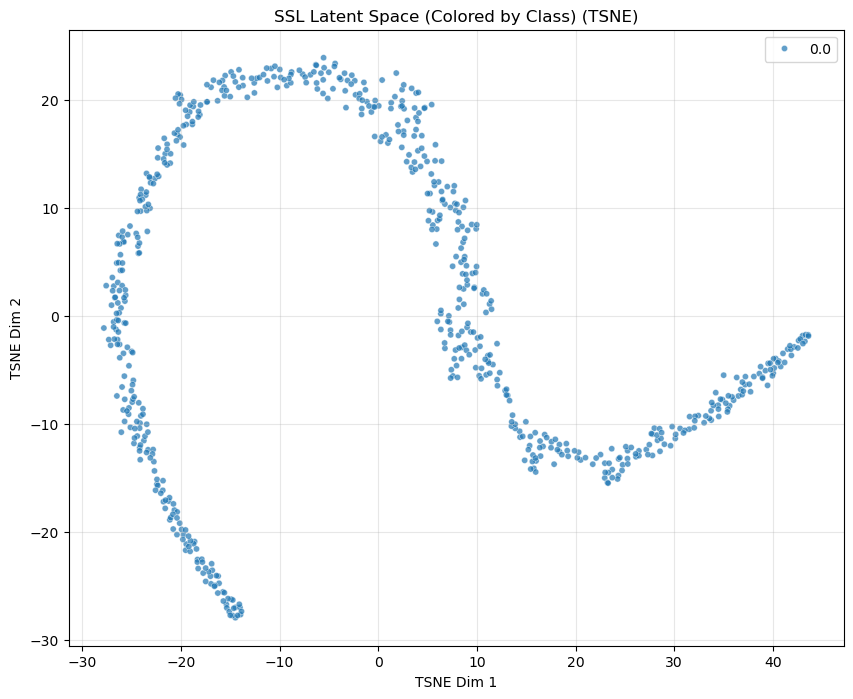

(array([[ 35.62998  ,  -8.334614 ],
        [  4.415213 ,  16.66855  ],
        [ 25.26614  , -13.229747 ],
        ...,
        [ -1.4569933,  21.599997 ],
        [-24.681063 , -10.447992 ],
        [-15.70849  , -26.41684  ]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [14]:
from dataloaders.core import load_and_split_data
from torch.utils.data import TensorDataset, DataLoader
from models.ssl_transformer import SSL_Transformer

# This will pass X through model.backbone.encode() and color by y_test
plot_ssl_embeddings(model, train_loader, device=device, method='tsne', title="SSL Latent Space (Colored by Class)")